In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


## Neural Part Of Speech Tagging

We're now going to solve the same problem of POS tagging with neural networks.
<img src=https://i.stack.imgur.com/6pdIT.png width=320>

From deep learning perspective, this is a task of predicting a sequence of outputs aligned to a sequence of inputs. There are several problems that match this formulation:
* Part Of Speech Tagging -  an auxuliary task for many NLP problems
* Named Entity Recognition - for chat bots and web crawlers
* Protein structure prediction - for bioinformatics

In [2]:
import nltk
import sys
import numpy as np

nltk.download('brown')
nltk.download('universal_tagset')
data = nltk.corpus.brown.tagged_sents(tagset='universal')
all_tags = ['#EOS#','#UNK#','ADV', 'NOUN', 'ADP', 'PRON', 'DET', '.', 'PRT', 'VERB', 'X', 'NUM', 'CONJ', 'ADJ']

data = np.array([ [(word.lower(),tag) for word,tag in sentence] for sentence in data ])

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [3]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data,test_size=0.25,random_state=42)

In [4]:
from IPython.display import HTML, display
def draw(sentence):
    words,tags = zip(*sentence)
    display(HTML('<table><tr>{tags}</tr>{words}<tr></table>'.format(
                words = '<td>{}</td>'.format('</td><td>'.join(words)),
                tags = '<td>{}</td>'.format('</td><td>'.join(tags)))))
    
    
draw(data[11])
draw(data[10])
draw(data[7])

NOUN,ADP,NOUN,NOUN,NOUN,NOUN,VERB,ADV,VERB,ADP,DET,ADJ,NOUN,.,implementation,of,georgia's,automobile,title,law,was,also,recommended,by,the,outgoing,jury,.


PRON,VERB,ADP,DET,NOUN,.,VERB,NOUN,PRT,VERB,.,DET,NOUN,.,it,urged,that,the,city,``,take,steps,to,remedy,'',this,problem,.


NOUN,VERB,merger,proposed


### Building vocabularies

Just like before, we have to build a mapping from tokens to integer ids. This time around, our model operates on a word level, processing one word per RNN step. This means we'll have to deal with far larger vocabulary.

Luckily for us, we only receive those words as input i.e. we don't have to predict them. This means we can have a large vocabulary for free by using word embeddings.

In [5]:
from collections import Counter
word_counts = Counter()
for sentence in data:
    words,tags = zip(*sentence)
    word_counts.update(words)

all_words = ['#EOS#','#UNK#'] + list(list(zip(*word_counts.most_common(10000)))[0])

#let's measure what fraction of data words are in the dictionary
print("Coverage = %.5f" % (float(sum(word_counts[w] for w in all_words)) / sum(word_counts.values())))

Coverage = 0.92876


In [6]:
from collections import defaultdict
word_to_id = defaultdict(lambda:1, { word: i for i, word in enumerate(all_words) })
tag_to_id = { tag: i for i, tag in enumerate(all_tags)}

convert words and tags into fixed-size matrix

In [7]:
def to_matrix(lines, token_to_id, max_len=None, pad=0, dtype='int32', time_major=False):
    """Converts a list of names into rnn-digestable matrix with paddings added after the end"""
    
    max_len = max_len or max(map(len,lines))
    matrix = np.empty([len(lines), max_len],dtype)
    matrix.fill(pad)

    for i in range(len(lines)):
        line_ix = list(map(token_to_id.__getitem__,lines[i]))[:max_len]
        matrix[i,:len(line_ix)] = line_ix

    return matrix.T if time_major else matrix



In [8]:
batch_words, batch_tags = zip(*[zip(*sentence) for sentence in data[-3:]])

print("Word ids:")
print(to_matrix(batch_words, word_to_id))
print("Tag ids:")
print(to_matrix(batch_tags, tag_to_id))

Word ids:
[[   2 3057    5    2 2238 1334 4238 2454    3    6   19   26 1070   69
     8 2088    6    3    1    3  266   65  342    2    1    3    2  315
     1    9   87  216 3322   69 1558    4    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [  45   12    8  511 8419    6   60 3246   39    2    1    1    3    2
   845    1    3    1    3   10 9910    2    1 3470    9   43    1    1
     3    6    2 1046  385   73 4562    3    9    2    1    1 3250    3
    12   10    2  861 5240   12    8 8936  121    1    4]
 [  33   64   26   12  445    7 7346    9    8 3337    3    1 2811    3
     2  463  572    2    1    1 1649   12    1    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
Tag ids:
[[ 6  3  4  6  3  3  9  9  7 12  4  5  9  4  6  3 12  7  9  7  9  8  4  6
   3  7  6 13  3  4  6  3  9  4  3  7  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0

### Build model

Unlike our previous lab, this time we'll focus on a high-level keras interface to recurrent neural networks. It is as simple as you can get with RNN, allbeit somewhat constraining for complex tasks like seq2seq.

By default, all keras RNNs apply to a whole sequence of inputs and produce a sequence of hidden states `(return_sequences=True` or just the last hidden state `(return_sequences=False)`. All the recurrence is happening under the hood.

At the top of our model we need to apply a Dense layer to each time-step independently. As of now, by default keras.layers.Dense would apply once to all time-steps concatenated. We use __keras.layers.TimeDistributed__ to modify Dense layer so that it would apply across both batch and time axes.

In [9]:
import keras
import keras.layers as L

model = keras.models.Sequential()
model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.SimpleRNN(64,return_sequences=True))

#add top layer that predicts tag probabilities
stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


__Training:__ in this case we don't want to prepare the whole training dataset in advance. The main cause is that the length of every batch depends on the maximum sentence length within the batch. This leaves us two options: use custom training code as in previous seminar or use generators.

Keras models have a __`model.fit_generator`__ method that accepts a python generator yielding one batch at a time. But first we need to implement such generator:

In [10]:
from keras.utils.np_utils import to_categorical
BATCH_SIZE=32
def generate_batches(sentences,batch_size=BATCH_SIZE,max_len=None,pad=0):
    assert isinstance(sentences,np.ndarray),"Make sure sentences is q numpy array"
    
    while True:
        indices = np.random.permutation(np.arange(len(sentences)))
        for start in range(0,len(indices)-1,batch_size):
            batch_indices = indices[start:start+batch_size]
            batch_words,batch_tags = [],[]
            for sent in sentences[batch_indices]:
                words,tags = zip(*sent)
                batch_words.append(words)
                batch_tags.append(tags)

            batch_words = to_matrix(batch_words,word_to_id,max_len,pad)
            batch_tags = to_matrix(batch_tags,tag_to_id,max_len,pad)

            batch_tags_1hot = to_categorical(batch_tags,len(all_tags)).reshape(batch_tags.shape+(-1,))
            yield batch_words,batch_tags_1hot
        

In [ ]:
g = generate_batches(train_data)
next(g)[1].shape

(32, 62, 14)

__Callbacks:__ Another thing we need is to measure model performance. The tricky part is not to count accuracy after sentence ends (on padding) and making sure we count all the validation data exactly once.

While it isn't impossible to persuade Keras to do all of that, we may as well write our own callback that does that.
Keras callbacks allow you to write a custom code to be ran once every epoch or every minibatch. We'll define one via LambdaCallback

In [11]:
def compute_test_accuracy(model):
    test_words,test_tags = zip(*[zip(*sentence) for sentence in test_data])
    test_words,test_tags = to_matrix(test_words,word_to_id),to_matrix(test_tags,tag_to_id)

    #predict tag probabilities of shape [batch,time,n_tags]
    predicted_tag_probabilities = model.predict(test_words,verbose=1)
    predicted_tags = predicted_tag_probabilities.argmax(axis=-1)

    #compute accurary excluding padding
    numerator = np.sum(np.logical_and((predicted_tags == test_tags),(test_words != 0)))
    denominator = np.sum(test_words != 0)
    return float(numerator)/denominator


class EvaluateAccuracy(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        sys.stdout.flush()
        print("\nMeasuring validation accuracy...")
        acc = compute_test_accuracy(self.model)
        print("\nValidation accuracy: %.5f\n"%acc)
        sys.stdout.flush()
        

In [12]:
model.compile('adam','categorical_crossentropy')

model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=5,)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/5
1344/1343 [==============================] - 29s 21ms/step - loss: 0.2444

Measuring validation accuracy...
14335/14335 [==============================] - 5s 327us/step

Validation accuracy: 0.94083

Epoch 2/5
1344/1343 [==============================] - 30s 22ms/step - loss: 0.0575

Measuring validation accuracy...
14335/14335 [==============================] - 5s 335us/step

Validation accuracy: 0.94452

Epoch 3/5
1344/1343 [==============================] - 30s 22ms/step - loss: 0.0513

Measuring validation accuracy...
14335/14335 [==============================] - 5s 330us/step

Validation accuracy: 0.94654

Epoch 4/5
1344/1343 [==============================] - 29s 21ms/step - loss: 0.0467

Measuring validation accuracy...
14335/14335 [==============================] - 5s 337us/step

Validation accuracy: 0.94577

Epoch 5/5
1344/1343 [==============================] - 30s 22ms/s

Measure final accuracy on the whole test set.

In [ ]:
acc = compute_test_accuracy(model)
print("Final accuracy: %.5f"%acc)

assert acc>0.94, "Keras has gone on a rampage again, please contact course staff."

14335/14335 [==============================] - 4s 307us/step
Final accuracy: 0.94618


### Going bidirectional

Since we're analyzing a full sequence, it's legal for us to look into future data.

A simple way to achieve that is to go both directions at once, making a __bidirectional RNN__.

In Keras you can achieve that both manually (using two LSTMs and Concatenate) and by using __`keras.layers.Bidirectional`__. 

This one works just as `TimeDistributed` we saw before: you wrap it around a recurrent layer (SimpleRNN now and LSTM/GRU later) and it actually creates two layers under the hood.

Your first task is to use such a layer our POS-tagger.

In [18]:
#Define a model that utilizes bidirectional SimpleRNN
model = keras.models.Sequential()

model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.Bidirectional(L.SimpleRNN(64,return_sequences=True)))
stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

In [19]:
model.compile('adam','categorical_crossentropy')

model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=5,)

Epoch 1/5
1344/1343 [==============================] - 44s 33ms/step - loss: 0.1877

Measuring validation accuracy...
14335/14335 [==============================] - 9s 632us/step

Validation accuracy: 0.95727

Epoch 2/5
1344/1343 [==============================] - 44s 33ms/step - loss: 0.0420

Measuring validation accuracy...
14335/14335 [==============================] - 8s 586us/step

Validation accuracy: 0.96057

Epoch 3/5
1344/1343 [==============================] - 44s 33ms/step - loss: 0.0348

Measuring validation accuracy...
14335/14335 [==============================] - 8s 581us/step

Validation accuracy: 0.96261

Epoch 4/5
1344/1343 [==============================] - 44s 33ms/step - loss: 0.0295

Measuring validation accuracy...
14335/14335 [==============================] - 8s 580us/step

Validation accuracy: 0.96184

Epoch 5/5
1344/1343 [==============================] - 44s 33ms/step - loss: 0.0247

Measuring validation accuracy...
14335/14335 [=============================

In [20]:
acc = compute_test_accuracy(model)
print("\nFinal accuracy: %.5f"%acc)

assert acc>0.96, "Bidirectional RNNs are better than this!"
print("Well done!")

14335/14335 [==============================] - 8s 583us/step

Final accuracy: 0.96107
Well done!


Task I: Structured loss functions (more bonus points)

Since we're tagging the whole sequence at once, we might as well train our network to do so. Remember linear CRF from the lecture? You can also use it as a loss function for your RNN


  * There's more than one way to do so, but we'd recommend starting with [Conditional Random Fields](http://blog.echen.me/2012/01/03/introduction-to-conditional-random-fields/)
  * You can plug CRF as a loss function and still train by backprop. There's even some neat tensorflow [implementation](https://www.tensorflow.org/api_guides/python/contrib.crf) for you.
  * Alternatively, you can condition your model on previous tags (make it autoregressive) and perform __beam search__ over that model.

In [13]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-skin3bg4
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-skin3bg4
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=f166d6ca9b378e79a510182d2aeeb86c1db42e373e505c8eb82205c51c353d4b
  Stored in directory: /tmp/pip-ephem-wheel-cache-2uzxyx8s/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [14]:
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy

In [ ]:
model = keras.models.Sequential()
model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.Bidirectional(L.SimpleRNN(64,return_sequences=True)))
stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)
crf = CRF(len(all_tags))  # CRF layer
model.add(crf)

model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 50)          500100    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, None, 128)         14720     
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 14)          1806      
_________________________________________________________________
crf_9 (CRF)                  (None, None, 14)          434       
Total params: 517,060
Trainable params: 517,060
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=20,)

Epoch 1/20
1344/1343 [==============================] - 100s 75ms/step - loss: 0.9344 - crf_viterbi_accuracy: 0.7834

Measuring validation accuracy...
14335/14335 [==============================] - 32s 2ms/step

Validation accuracy: 0.60640

Epoch 2/20
1344/1343 [==============================] - 100s 75ms/step - loss: 0.3907 - crf_viterbi_accuracy: 0.8636

Measuring validation accuracy...
14335/14335 [==============================] - 32s 2ms/step

Validation accuracy: 0.71483

Epoch 3/20
1344/1343 [==============================] - 100s 75ms/step - loss: 0.2746 - crf_viterbi_accuracy: 0.9035

Measuring validation accuracy...
14335/14335 [==============================] - 32s 2ms/step

Validation accuracy: 0.75804

Epoch 4/20
1344/1343 [==============================] - 105s 78ms/step - loss: 0.2305 - crf_viterbi_accuracy: 0.9189

Measuring validation accuracy...
14335/14335 [==============================] - 33s 2ms/step

Validation accuracy: 0.83016

Epoch 5/20
1344/1343 [==========

In [ ]:
acc = compute_test_accuracy(model)
print("\nFinal accuracy: %.5f"%acc)

14335/14335 [==============================] - 29s 2ms/step

Final accuracy: 0.94984


Стало несколько хуже. Посмотрим, что можно сделать:

In [ ]:
import keras.callbacks as c

In [ ]:
model = keras.models.Sequential()
model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))

model.add(L.Bidirectional(L.LSTM(256,return_sequences=True)))
model.add(L.Conv1D(filters=8, kernel_size=2, padding='same', activation='relu'))
model.add(L.Dropout(0.2))

model.add(L.Bidirectional(L.LSTM(64,return_sequences=True)))
model.add(L.Dropout(0.5))

stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)
crf = CRF(len(all_tags))  # CRF layer
model.add(crf)

model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 50)          500100    
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 512)         628736    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 8)           8200      
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 8)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 128)         37376     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 14)         

In [ ]:
model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=20, )

Epoch 1/20
1344/1343 [==============================] - 225s 168ms/step - loss: 1.0612 - crf_viterbi_accuracy: 0.6803

Measuring validation accuracy...
14335/14335 [==============================] - 57s 4ms/step

Validation accuracy: 0.22934

Epoch 2/20
1344/1343 [==============================] - 224s 167ms/step - loss: 0.6715 - crf_viterbi_accuracy: 0.7120

Measuring validation accuracy...
14335/14335 [==============================] - 58s 4ms/step

Validation accuracy: 0.23079

Epoch 3/20
1344/1343 [==============================] - 224s 167ms/step - loss: 0.6531 - crf_viterbi_accuracy: 0.7110

Measuring validation accuracy...
14335/14335 [==============================] - 58s 4ms/step

Validation accuracy: 0.23079

Epoch 4/20
1344/1343 [==============================] - 226s 168ms/step - loss: 0.6401 - crf_viterbi_accuracy: 0.7120

Measuring validation accuracy...
14335/14335 [==============================] - 58s 4ms/step

Validation accuracy: 0.23079

Epoch 5/20
1344/1343 [======

Улучшила ситуацию замена SimpleRNN на LSTM с units=256. Final accuracy: 0.90696   
Увеличение числа эпох дали  Validation accuracy: 0.91833   
Второй слой LSTM и 2 слоя Dropout дали Validation accuracy: 0.96365  
Добавила Conv1D - снова качество упало. Validation accuracy: 0.91466   
Продолжаем эксперимент.



Добавим в модель предобученный слой эмбеддинга:

In [ ]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
dict_all_words = {}
val = range(100002)
for i in range(len(all_words)):
  dict_all_words[all_words[i]] = val[i]

In [ ]:
words = 5000

In [ ]:
EMBEDDING_DIM=300
vocabulary_size=min(len(all_words)+1,words)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, index in dict_all_words.items():
    if index>=words:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[index] = embedding_vector
    except KeyError:
        embedding_matrix[index]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [ ]:
model = keras.models.Sequential()
model.add(L.InputLayer([None],dtype='int32'))
model.add(embedding_layer)

model.add(L.Bidirectional(L.LSTM(256,return_sequences=True)))
model.add(L.Dropout(0.2))

model.add(L.Bidirectional(L.LSTM(64,return_sequences=True)))
model.add(L.Dropout(0.5))

stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)
crf = CRF(len(all_tags))  # CRF layer
model.add(crf)

model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 300)         1500000   
_________________________________________________________________
bidirectional_9 (Bidirection (None, None, 512)         1140736   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 8)           8200      
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 8)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, None, 128)         37376     
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 14)         

In [ ]:
%%time
model.fit_generator(generate_batches(train_data),len(all_words)/BATCH_SIZE, epochs=20, 
                    verbose=1, callbacks=[EvaluateAccuracy()],) 

Epoch 1/20
313/312 [==============================] - 51s 164ms/step - loss: 1.4998 - crf_viterbi_accuracy: 0.6216

Measuring validation accuracy...
14335/14335 [==============================] - 57s 4ms/step

Validation accuracy: 0.02342

Epoch 2/20
313/312 [==============================] - 52s 166ms/step - loss: 0.8141 - crf_viterbi_accuracy: 0.7093

Measuring validation accuracy...
14335/14335 [==============================] - 56s 4ms/step

Validation accuracy: 0.46249

Epoch 3/20
313/312 [==============================] - 49s 158ms/step - loss: 0.6479 - crf_viterbi_accuracy: 0.8008

Measuring validation accuracy...
14335/14335 [==============================] - 56s 4ms/step

Validation accuracy: 0.48354

Epoch 4/20
313/312 [==============================] - 50s 158ms/step - loss: 0.5769 - crf_viterbi_accuracy: 0.8041

Measuring validation accuracy...
14335/14335 [==============================] - 56s 4ms/step

Validation accuracy: 0.49384

Epoch 5/20
313/312 [====================

С предобученными эмбеддингами результат стал намного хуже. Возможно, стоит использовать другие варианты текстов.  
А если нам уменьшить количество слов?

In [ ]:
words = 1000

In [ ]:
model = keras.models.Sequential()
model.add(L.InputLayer([None],dtype='int32'))
model.add(embedding_layer)

model.add(L.Bidirectional(L.LSTM(256,return_sequences=True)))
model.add(L.Dropout(0.2))

model.add(L.Bidirectional(L.LSTM(64,return_sequences=True)))
model.add(L.Dropout(0.5))

stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)
crf = CRF(len(all_tags))  # CRF layer
model.add(crf)

model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 300)         1500000   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, None, 512)         1140736   
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, None, 128)         295424    
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 14)          1806      
_________________________________________________________________
crf_6 (CRF)                  (None, None, 14)         

In [ ]:
model.fit_generator(generate_batches(train_data),len(all_words)/BATCH_SIZE, epochs=20, 
                    verbose=1, callbacks=[EvaluateAccuracy()],) 

Epoch 1/20
313/312 [==============================] - 54s 171ms/step - loss: 1.8175 - crf_viterbi_accuracy: 0.6254

Measuring validation accuracy...
14335/14335 [==============================] - 59s 4ms/step

Validation accuracy: 0.48025

Epoch 2/20
313/312 [==============================] - 52s 167ms/step - loss: 0.9580 - crf_viterbi_accuracy: 0.8072

Measuring validation accuracy...
14335/14335 [==============================] - 58s 4ms/step

Validation accuracy: 0.48308

Epoch 3/20
313/312 [==============================] - 52s 167ms/step - loss: 0.6532 - crf_viterbi_accuracy: 0.8090

Measuring validation accuracy...
14335/14335 [==============================] - 58s 4ms/step

Validation accuracy: 0.48795

Epoch 4/20
313/312 [==============================] - 51s 163ms/step - loss: 0.5651 - crf_viterbi_accuracy: 0.8071

Measuring validation accuracy...
14335/14335 [==============================] - 58s 4ms/step

Validation accuracy: 0.49423

Epoch 5/20
313/312 [====================

Стало лучше, но до идеала далеко.

В общем, наилучшим образом показала себя модель с двумя слоями LSTM и двумя слоями Dropout. Поработаем с ней: поменяем оптимизатор на Adamax:

In [ ]:
model = keras.models.Sequential()
model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))

model.add(L.Bidirectional(L.LSTM(256,return_sequences=True)))
model.add(L.Dropout(0.2))

model.add(L.Bidirectional(L.LSTM(64,return_sequences=True)))
model.add(L.Dropout(0.5))

stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)
crf = CRF(len(all_tags))  # CRF layer
model.add(crf)

model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 50)          500100    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, None, 512)         628736    
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 512)         0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, None, 128)         295424    
_________________________________________________________________
dropout_17 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 14)          1806      
_________________________________________________________________
crf_10 (CRF)                 (None, None, 14)        

In [ ]:
%%time
model.fit_generator(generate_batches(train_data),len(all_words)/BATCH_SIZE, epochs=20, 
                    verbose=1, callbacks=[EvaluateAccuracy()],) 

Epoch 1/20
313/312 [==============================] - 52s 167ms/step - loss: 1.7160 - crf_viterbi_accuracy: 0.5958

Measuring validation accuracy...
14335/14335 [==============================] - 59s 4ms/step

Validation accuracy: 0.00091

Epoch 2/20
313/312 [==============================] - 51s 162ms/step - loss: 0.9535 - crf_viterbi_accuracy: 0.6255

Measuring validation accuracy...
14335/14335 [==============================] - 57s 4ms/step

Validation accuracy: 0.05996

Epoch 3/20
313/312 [==============================] - 51s 164ms/step - loss: 0.6958 - crf_viterbi_accuracy: 0.7207

Measuring validation accuracy...
14335/14335 [==============================] - 57s 4ms/step

Validation accuracy: 0.36104

Epoch 4/20
313/312 [==============================] - 50s 159ms/step - loss: 0.6218 - crf_viterbi_accuracy: 0.7559

Measuring validation accuracy...
14335/14335 [==============================] - 57s 4ms/step

Validation accuracy: 0.35737

Epoch 5/20
313/312 [====================

Изменим оптимизатор на Adamax и снесём всё, что связано с CRF:

In [23]:
model = keras.models.Sequential()
model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))

model.add(L.Bidirectional(L.LSTM(128,return_sequences=True)))
model.add(L.Dropout(0.2))

model.add(L.Bidirectional(L.LSTM(64,return_sequences=True)))
model.add(L.Dropout(0.5))

stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

model.compile("Adamax", 'categorical_crossentropy')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 50)          500100    
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 256)         183296    
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 128)         164352    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 14)          1806      
Total params: 849,554
Trainable params: 849,554
Non-trainable params: 0
________________________________________________

In [24]:
%%time
history = model.fit_generator(generate_batches(train_data),len(all_words)/BATCH_SIZE, epochs=20, 
                    verbose=1, callbacks=[EvaluateAccuracy()],) 

Epoch 1/20
313/312 [==============================] - 74s 237ms/step - loss: 0.8473

Measuring validation accuracy...
14335/14335 [==============================] - 55s 4ms/step

Validation accuracy: 0.30542

Epoch 2/20
313/312 [==============================] - 71s 228ms/step - loss: 0.5874

Measuring validation accuracy...
14335/14335 [==============================] - 54s 4ms/step

Validation accuracy: 0.75116

Epoch 3/20
313/312 [==============================] - 72s 231ms/step - loss: 0.2321

Measuring validation accuracy...
14335/14335 [==============================] - 55s 4ms/step

Validation accuracy: 0.89252

Epoch 4/20
313/312 [==============================] - 72s 229ms/step - loss: 0.1440

Measuring validation accuracy...
14335/14335 [==============================] - 55s 4ms/step

Validation accuracy: 0.92148

Epoch 5/20
313/312 [==============================] - 71s 226ms/step - loss: 0.1122

Measuring validation accuracy...
14335/14335 [==============================] -

In [32]:
acc = compute_test_accuracy(model)
print("\nFinal accuracy: %.5f"%acc)

assert acc>0.96, "Bidirectional RNNs are better than this!"
print("Well done!")

14335/14335 [==============================] - 55s 4ms/step

Final accuracy: 0.96280
Well done!


Итак, самый лучший показатель accuracy:
- Validation accuracy: 0.96280; 
- Final accuracy: 0.96280.  
Разумеется, можно и лучше. Будем над этим работать)

И отобразим графики:

In [26]:
import matplotlib.pyplot as plt

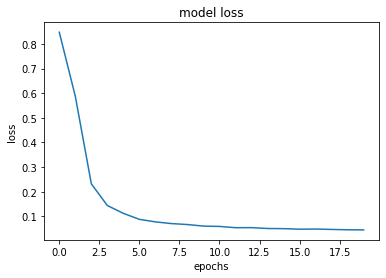

In [31]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

Наша loss function стремится к нулю, причем всё ближе на каждой последующей итерации.

Что можно сказать о тегах?

In [ ]:
import pylab

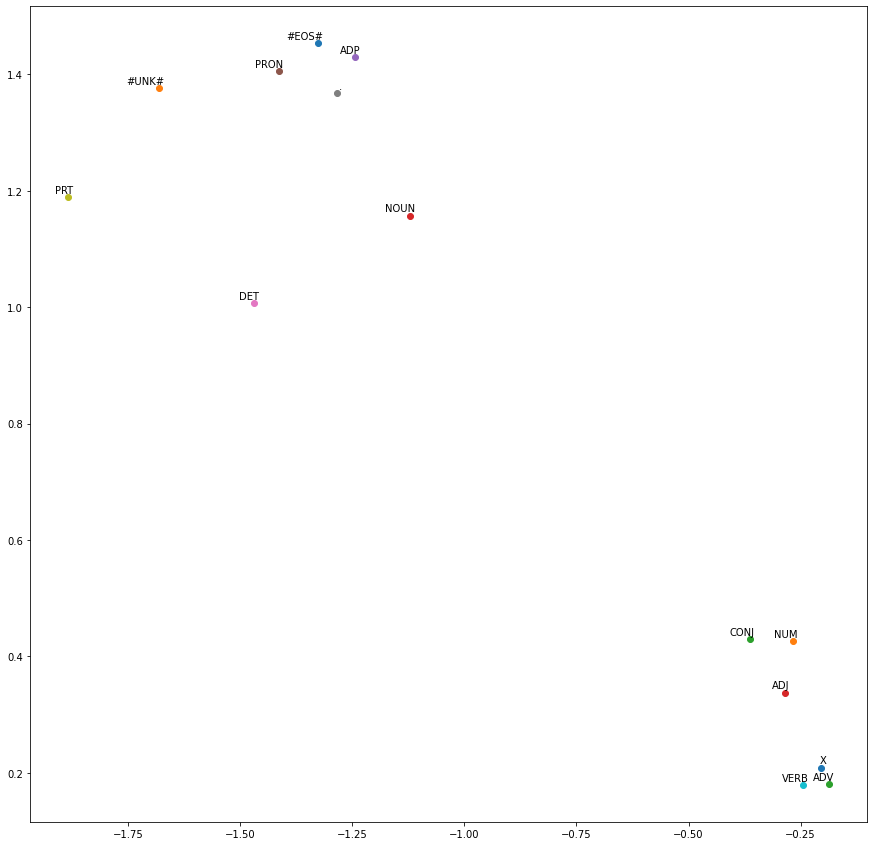

In [ ]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = all_tags
matrix = []
for i in embedding_matrix:
  matrix.append([min(i), max(i)])
plot(np.array(matrix), words)

Итак, на графике рассеяния отчетливо видно, как несколько частей речи формируют что-то типа кластеров. Так, например, рядом находятся глагол, наречие и "х" (другие части речи). Поскольку основные части речи названы, то можно предположить, что другие - это, например, причастие или деепричастие. А ведь они в большинстве своем образованы от глаголов, так что вполне могут существовать рядом.  
Еще стоит отметить дальность существительных от остальных частей.   
Отдельной группкой идут местоимения, точки, знаки, а также тэг окончания последовательности.  
Неопознанные слова тоже присутствуют, но чуть поодаль. Они не относятся к общему кластеру, а отделены от всех.  
В целом картина вполне логичная.  
Что можно сказать про слова?

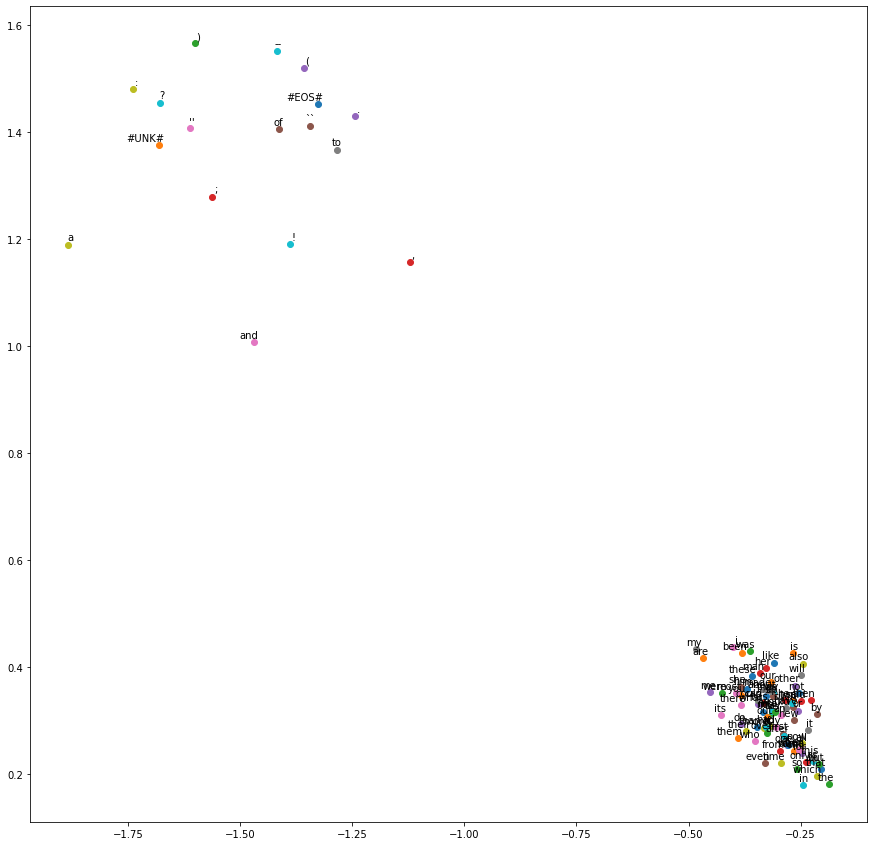

In [ ]:
plot(np.array(matrix), all_words[:50])

Очень наглядна ситуация со словами: все значимые слова сгруппированы в правом нижнем углу. Менее плотный кластер - верхний левый угол - занимают знаки, частицы, предлоги. Там же встречаются все слова, что модель определила как #UNK# и #EOS#.  
Тоже вполне логичное распределение. Из этого следует вывод, что части речи определяются достаточно точно.


#### Some tips
Here there are a few more tips on how to improve training that are a bit trickier to impliment. We strongly suggest that you try them _after_ you've got a good initial model.
* __Use pre-trained embeddings__: you can use pre-trained weights from [there](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) to kickstart your Embedding layer.
  * Embedding layer has a matrix W (layer.W) which contains word embeddings for each word in the dictionary. You can just overwrite them with tf.assign.
  * When using pre-trained embeddings, pay attention to the fact that model's dictionary is different from your own.
  * You may want to switch trainable=False for embedding layer in first few epochs as in regular fine-tuning.  
* __Go beyond SimpleRNN__: there's `keras.layers.LSTM` and `keras.layers.GRU`
  * If you want to use a custom recurrent Cell, read [this](https://keras.io/layers/recurrent/#rnn)
  * You can also use 1D Convolutions (`keras.layers.Conv1D`). They are often as good as recurrent layers but with less overfitting.
* __Stack more layers__: if there is a common motif to this course it's about stacking layers
  * You can just add recurrent and 1dconv layers on top of one another and keras will understand it
  * Just remember that bigger networks may need more epochs to train
* __Regularization__: you can apply dropouts as usual but also in an RNN-specific way
  * `keras.layers.Dropout` works inbetween RNN layers
  * Recurrent layers also have `recurrent_dropout` parameter
* __Gradient clipping__: If your training isn't as stable as you'd like, set `clipnorm` in your optimizer.
  * Which is to say, it's a good idea to watch over your loss curve at each minibatch. Try tensorboard callback or something similar.
* __Word Dropout__: tl;dr randomly replace words with UNK during training. 
  * This can also simulate increased amount of unknown words in the test set
* __Larger vocabulary__: You can obtain greater performance by expanding your model's input dictionary from 5000 to up to every single word!
  * Just make sure your model doesn't overfit due to so many parameters.
  * Combined with regularizers or pre-trained word-vectors this could be really good cuz right now our model is blind to >5% of words.  
* __More efficient batching__: right now TF spends a lot of time iterating over "0"s
  * This happens because batch is always padded to the length of a longest sentence
  * You can speed things up by pre-generating batches of similar lengths and feeding it with randomly chosen pre-generated batch.
  * This technically breaks the i.i.d. assumption, but it works unless you come up with some insane rnn architectures.
* __The most important advice__: don't cram in everything at once!
  * If you stuff in a lot of modiffications, some of them almost inevitably gonna be detrimental and you'll never know which of them are.
  * Try to instead go in small iterations and record experiment results to guide further search.
    
Good hunting!